# Get started with Flower

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using the Flower framework, Flower Datasets and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we federate the PyTorch project using Flower.

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Flower Discuss and the Flower Slack to connect, ask questions, and get help:
> - [Join Flower Discuss](https://discuss.flower.ai/) We'd love to hear from you in the `Introduction` topic! If anything is unclear, post in `Flower Help - Beginners`.
> - [Join Flower Slack](https://flower.ai/join-slack) We'd love to hear from you in the `#introductions` channel! If anything is unclear, head over to the `#questions` channel.

Let's get started! 🌼

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

c:\Users\tobbe\Documents\BTH\Ai-scurety\Security-in-AI-systems\flower_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-21 17:34:22,798	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu
Flower 1.13.0 / PyTorch 2.2.1+cpu


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware accelerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.

### Load the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'.

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (the data is naturally partitioned).

Each organization will act as a client in the federated learning system. Having ten organizations participate in a federation means having ten clients connected to the federated learning server.


We use the Flower Datasets library (`flwr-datasets`) to partition CIFAR-10 into ten partitions using `FederatedDataset`. We will create a small training and test set for each of the ten organizations and wrap each of these into a PyTorch `DataLoader`:

## IID Partitioning

In [2]:
NUM_CLIENTS = 5
BATCH_SIZE = 32
ROUNDS = 5


def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

We now have a function that can return a training set and validation set (`trainloader` and `valloader`) representing one dataset from one of ten different organizations. Each `trainloader`/`valloader` pair contains 4000 training examples and 1000 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloader` from `partition_id=0`) before we move on:

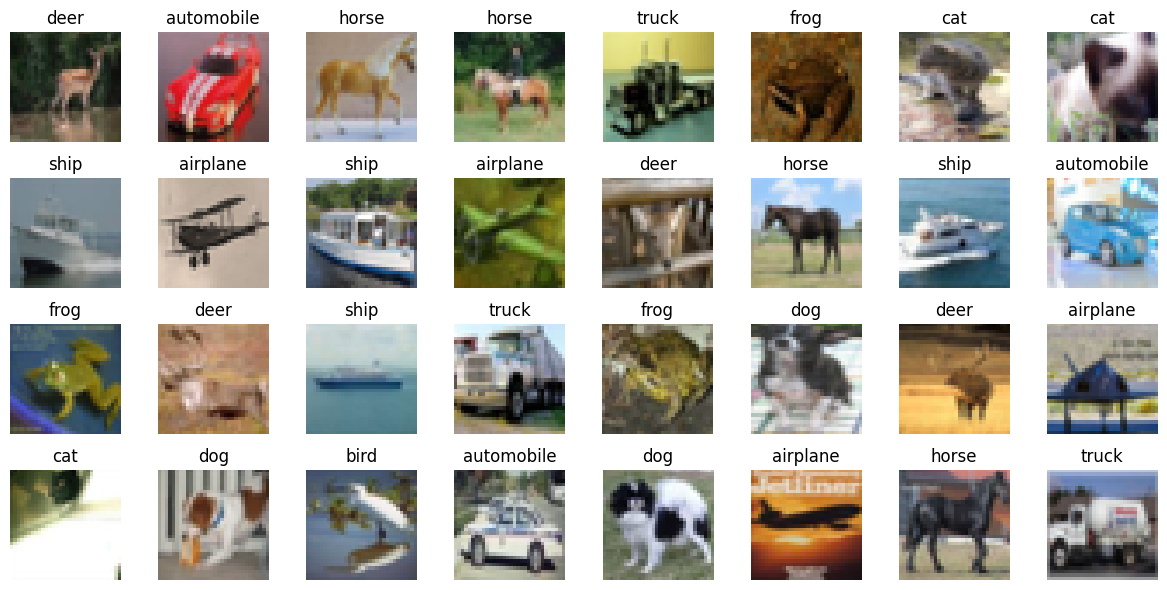

In [3]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the `trainloader` from the first of ten partitions. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## Step 1: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Define the model

We use the simple CNN described in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network):

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's continue with the usual training and test functions:

In [5]:
import random
def random_labels(batch):
    for index in range(len(batch["label"])):
        batch["label"][index] = random.randint(0,9)
    return batch

In [6]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score

def train(net, trainloader, epochs: int, verbose=False, corrupt=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            if corrupt:
                batch = random_labels(batch)

            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    # Convert all_preds to one-hot encoded format
    all_preds_one_hot = np.zeros((len(all_preds), 10))
    all_preds_one_hot[np.arange(len(all_preds)), all_preds] = 1

    roc = roc_auc_score(all_labels, all_preds_one_hot, multi_class='ovo')

    return loss, accuracy, f1, roc, kappa

## Step 2: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Update model parameters

In federated learning, the server sends global model parameters to the client, and the client updates the local model with parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which the Flower `NumPyClient` knows how to serialize/deserialize):

In [7]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Define the Flower ClientApp

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create a `ServerApp` and a `ClientApp` to run the server-side and client-side code, respectively.

The first step toward creating a `ClientApp` is to implement a subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate. To implement `NumPyClient`, we create a subclass that implements the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [8]:
ATTACKERS = 2

class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader,id):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        if self.id < ATTACKERS:
            print("Corrupting data")
            train(self.net, self.trainloader, epochs=1, corrupt=True)
        else:
            # print("Regular model")
            train(self.net, self.trainloader, epochs=1, corrupt=False)
        return get_parameters(self.net), len(self.trainloader), {}


Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient` (one on each of the machines we'd start the client on). Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 10 clients *on a single machine*. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function that creates a `FlowerClient` instance on demand. We typically call this function `client_fn`. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). In federated learning experiments using Flower, clients are identified by a partition ID, or `partition-id`. This `partition-id` is used to load different local data partitions for different clients, as can be seen below. The value of `partition-id` is retrieved from the `node_config` dictionary in the `Context` object, which holds the information that persists throughout each training round. 

With this, we have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. Last, but definitely not least, we create an instance of `ClientApp` and pass it the `client_fn`. `ClientApp` is the entrypoint that a running Flower client uses to call your code (as defined in, for example, `FlowerClient.fit`).

In [9]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

On the server side, we need to configure a strategy which encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg). Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters:

Similar to `ClientApp`, we create a `ServerApp` using a utility function `server_fn`. In `server_fn`, we pass an instance of `ServerConfig` for defining the number of federated learning rounds (`num_rounds`) and we also pass the previously created `strategy`. The `server_fn` returns a `ServerAppComponents` object containing the settings that define the `ServerApp` behaviour. `ServerApp` is the entrypoint that Flower uses to call all your server-side code (for example, the strategy).

### Run the training

In simulation, we often want to control the amount of resources each client can use. In the next cell, we specify a `backend_config` dictionary with the `client_resources` key (required) for defining the amount of CPU and GPU resources each client can access.

In [10]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [11]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from logging import INFO, WARNING
import pickle
from pathlib import Path
from flwr.common.logger import log
from flwr.common import parameters_to_ndarrays
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.fedavg import aggregate, aggregate_inplace
from typing import Optional, Union

class FedAvgWithModelSaving(flwr.server.strategy.FedAvg):
    """This is a custom strategy that behaves exactly like
    FedAvg with the difference of storing of the state of
    the global model to disk after each round.
    """
    def __init__(self, save_path: str, *args, **kwargs):
        self.save_path = Path(save_path)
        # Create directory if needed
        self.save_path.mkdir(exist_ok=True, parents=True)
        super().__init__(*args, **kwargs)

    def _save_global_model(self, server_round: int, parameters):
        """A new method to save the parameters to disk."""

        # convert parameters to list of NumPy arrays
        # this will make things easy if you want to load them into a
        # PyTorch or TensorFlow model later
        # Remove previous files in the folder
        for file in self.save_path.glob("parameters_round_*.pkl"):
            file.unlink()

        ndarrays = parameters_to_ndarrays(parameters)
        data = {'globa_parameters': ndarrays}
        filename = str(self.save_path/f"parameters_round_{server_round}.pkl")
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)
        log(INFO, f"Checkpoint saved to: {filename}")

    def evaluate(self, server_round: int, parameters):
        """Evaluate model parameters using an evaluation function."""
        # save the parameters to disk using a custom method
        self._save_global_model(server_round, parameters)

        # call the parent method so evaluation is performed as
        # FedAvg normally does.
        return super().evaluate(server_round, parameters)

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}


        counter = 1
        weighted_results = []
        for _, fit_res in results:
            #load para,eters frp, fit_res.parameters into a model
            tmp_net = Net()
            # Set the parameters of the model
            # print(parameters_to_ndarrays(fit_res.parameters))
            set_parameters(tmp_net, parameters_to_ndarrays(fit_res.parameters))
            # Evaluate the model
            _, valloader, testloader = load_datasets(partition_id=3)

            # Evaluate the parameters from the client
            loss, accuracy, f1, roc, kappa = test(tmp_net, testloader)
            # print(f"Model: {counter} Test loss: {loss} \nTest accuracy: {accuracy} \nF1 score: {f1} \nKappa score: {kappa} \nROC AUC score: {roc}")
            counter += 1

            #Removing bad clients that harm the model
            if accuracy > 0.2:
                # print("Model is good\n")
                weighted_results.append((parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples))


        # Convert results to parameters
        aggregated_ndarrays = aggregate(weighted_results)
        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated


In [17]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvgWithModelSaving(
        save_path="checkpoints",
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=5,
        min_evaluate_clients=5, #3
        min_available_clients=5,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)



# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)


# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: checkpoints\parameters_round_0.pkl
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=30740) Corrupting data
(ClientAppActor pid=31664) Corrupting data


INFO :      aggregate_fit: received 5 results and 0 failures


Model: 1 Test loss: 0.05504811304807663 
Test accuracy: 0.3643 
F1 score: 0.3454172165914698 
Kappa score: 0.29366666666666685 
ROC AUC score: 0.6468333333333333
Model is good

Model: 2 Test loss: 0.07208954157829285 
Test accuracy: 0.1003 
F1 score: 0.0193636247774804 
Kappa score: 0.0003333333333332966 
ROC AUC score: 0.5001666666666666
Model: 3 Test loss: 0.05403601988554001 
Test accuracy: 0.3562 
F1 score: 0.3147779738249321 
Kappa score: 0.28466666666666685 
ROC AUC score: 0.6423333333333334
Model is good

Model: 4 Test loss: 0.07206990847587585 
Test accuracy: 0.104 
F1 score: 0.027325784116452586 
Kappa score: 0.004444444444444473 
ROC AUC score: 0.5022222222222221


INFO :      Checkpoint saved to: checkpoints\parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Model: 5 Test loss: 0.05500784814357758 
Test accuracy: 0.3446 
F1 score: 0.32527349057466914 
Kappa score: 0.2717777777777779 
ROC AUC score: 0.635888888888889
Model is good



INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31664) Corrupting data


INFO :      aggregate_fit: received 5 results and 0 failures


Model: 1 Test loss: 0.07183867137432098 
Test accuracy: 0.1455 
F1 score: 0.07748341469270993 
Kappa score: 0.050555555555555354 
ROC AUC score: 0.5252777777777777
Model: 2 Test loss: 0.05079838283061981 
Test accuracy: 0.3955 
F1 score: 0.3625817498601432 
Kappa score: 0.32833333333333314 
ROC AUC score: 0.6641666666666666
Model is good

Model: 3 Test loss: 0.05072779566049576 
Test accuracy: 0.41 
F1 score: 0.39500137972669974 
Kappa score: 0.34444444444444433 
ROC AUC score: 0.6722222222222223
Model is good

Model: 4 Test loss: 0.07187743752002716 
Test accuracy: 0.1198 
F1 score: 0.061016724682185705 
Kappa score: 0.02200000000000002 
ROC AUC score: 0.511


INFO :      Checkpoint saved to: checkpoints\parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Model: 5 Test loss: 0.05049950197935105 
Test accuracy: 0.4015 
F1 score: 0.39150561487288016 
Kappa score: 0.3350000000000002 
ROC AUC score: 0.6675
Model is good



INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31664) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


Model: 1 Test loss: 0.047321802854537964 
Test accuracy: 0.441 
F1 score: 0.4158315217076886 
Kappa score: 0.37888888888888905 
ROC AUC score: 0.6894444444444445
Model is good

Model: 2 Test loss: 0.04818529890775681 
Test accuracy: 0.4315 
F1 score: 0.39751815025606996 
Kappa score: 0.3683333333333333 
ROC AUC score: 0.6841666666666667
Model is good

Model: 3 Test loss: 0.07167741911411285 
Test accuracy: 0.1299 
F1 score: 0.06589272982106446 
Kappa score: 0.033222222222222264 
ROC AUC score: 0.5166111111111111
Model: 4 Test loss: 0.04744942593574524 
Test accuracy: 0.4432 
F1 score: 0.4307956202758104 
Kappa score: 0.3813333333333333 
ROC AUC score: 0.6906666666666668
Model is good



INFO :      Checkpoint saved to: checkpoints\parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Model: 5 Test loss: 0.0718827555179596 
Test accuracy: 0.1105 
F1 score: 0.04749785696900555 
Kappa score: 0.011666666666666714 
ROC AUC score: 0.5058333333333332


INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=30740) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


Model: 1 Test loss: 0.07158388018608093 
Test accuracy: 0.1432 
F1 score: 0.08419172850828725 
Kappa score: 0.04800000000000004 
ROC AUC score: 0.5239999999999999
Model: 2 Test loss: 0.0715965451002121 
Test accuracy: 0.1368 
F1 score: 0.07835636287349158 
Kappa score: 0.040888888888888864 
ROC AUC score: 0.5204444444444444
Model: 3 Test loss: 0.047874776893854144 
Test accuracy: 0.4362 
F1 score: 0.4177085401412038 
Kappa score: 0.3735555555555554 
ROC AUC score: 0.6867777777777777
Model is good

Model: 4 Test loss: 0.04588969683647156 
Test accuracy: 0.4629 
F1 score: 0.4477201048078866 
Kappa score: 0.40322222222222237 
ROC AUC score: 0.7016111111111111
Model is good



INFO :      Checkpoint saved to: checkpoints\parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Model: 5 Test loss: 0.04551572695970535 
Test accuracy: 0.4703 
F1 score: 0.46004662665069507 
Kappa score: 0.4114444444444447 
ROC AUC score: 0.7057222222222221
Model is good



INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31664) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures


Model: 1 Test loss: 0.044933120745420455 
Test accuracy: 0.4731 
F1 score: 0.46110361442352876 
Kappa score: 0.41455555555555557 
ROC AUC score: 0.7072777777777777
Model is good

Model: 2 Test loss: 0.07128113491535187 
Test accuracy: 0.1687 
F1 score: 0.12240702136164971 
Kappa score: 0.07633333333333314 
ROC AUC score: 0.5381666666666667
Model: 3 Test loss: 0.07121113152503968 
Test accuracy: 0.1606 
F1 score: 0.11843935653956851 
Kappa score: 0.06733333333333336 
ROC AUC score: 0.5336666666666666
Model: 4 Test loss: 0.04382643471956253 
Test accuracy: 0.4877 
F1 score: 0.4770571605247597 
Kappa score: 0.4307777777777778 
ROC AUC score: 0.715388888888889
Model is good



INFO :      Checkpoint saved to: checkpoints\parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Model: 5 Test loss: 0.04473611689209938 
Test accuracy: 0.474 
F1 score: 0.4619292343628829 
Kappa score: 0.41555555555555546 
ROC AUC score: 0.7077777777777778
Model is good



INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 250.38s
INFO :      


(ClientAppActor pid=31724) Corrupting data


In [18]:
# Load the saved parameters
with open(f"checkpoints/parameters_round_{ROUNDS}.pkl", "rb") as h:
    data = pickle.load(h)
    global_parameters = data['globa_parameters']

# Load the model
net = Net()
set_parameters(net, global_parameters)

_, valloader, testloader = load_datasets(partition_id=3)

# Evaluate the model
loss, accuracy, f1, roc, kappa = test(net, testloader)
print(f"Test loss: {loss} \nTest accuracy: {accuracy} \nF1 score: {f1} \nKappa score: {kappa} \nROC AUC score: {roc}")

Test loss: 0.04329573037028313 
Test accuracy: 0.5005 
F1 score: 0.4908042399278711 
Kappa score: 0.44499999999999995 
ROC AUC score: 0.7224999999999999
